# Predicting Customer Churn in GYM with Supervised Machine Learning

## Background:
"It's necessary to implement an effective customer retention strategy through data analysis. The main goal is to predict the probability of customer churn for the next month, identify key customer profiles, and develop specific recommendations to improve customer retention and satisfaction. This will enable optimizing the customer experience and strengthening their loyalty."

Behavior features of customers to predict churn and determine churn rate




# Dataset used:
The dataset being used is from Kaggle Dataset link: https://www.kaggle.com/datasets/adrianvinueza/gym-customers-features-and-churn

The dataset has 4000 records and 14 attributes

In [2]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.4/124.9 MB 8.2 MB/s eta 0:00:16
   ---------------------------------------- 0.8/124.9 MB 8.6 MB/s eta 0:00:15
    --------------------------------------- 1.6/124.9 MB 10.0 MB/s eta 0:00:13
    --------------------------------------- 2.8/124.9 MB 13.6 MB/s eta 0:00:10
   - -------------------------------------- 4.2/124.9 MB 16.7 MB/s eta 0:00:08
   - -------------------------------------- 5.6/124.9 MB 18.7 MB/s eta 0:00:07
   -- ------------------------------------- 6.9/124.9 MB 19.1 MB/s eta 0:00:07
   -- ------------------------------------- 8.0/124.9 MB 20.5 MB/s eta 0:00:06
   -- ------------------------------------- 9.2/124.9 MB 20.4 MB/s eta 0:00:06
   --- --------

In [5]:

#import statements

from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

#reading the dataset from drive
data=pd.read_csv('gym_churn_us.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

## Data Cleaning

In [7]:
# Handling missing values, encoding categorical variables, scaling numerical variables

# Identify columns with missing values
missing_values = data.isnull().sum()
missing_values.info()
# Impute missing values for numerical columns with median
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Impute missing values for categorical columns with mode
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if data[col].isnull().any():
        mode_value = data[col].mode()
        if not mode_value.empty:
            data[col].fillna(mode_value[0], inplace=True)

# Encoding categorical variables using OneHotEncoder
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

<class 'pandas.core.series.Series'>
Index: 14 entries, gender to Churn
Series name: None
Non-Null Count  Dtype
--------------  -----
14 non-null     int64
dtypes: int64(1)
memory usage: 224.0+ bytes


# Exploratory Data Analysis

In [10]:

#To find missing values
data.count()

gender                               4000
Near_Location                        4000
Partner                              4000
Promo_friends                        4000
Phone                                4000
Contract_period                      4000
Group_visits                         4000
Age                                  4000
Avg_additional_charges_total         4000
Month_to_end_contract                4000
Lifetime                             4000
Avg_class_frequency_total            4000
Avg_class_frequency_current_month    4000
Churn                                4000
dtype: int64

In [12]:
#To find missing values
data.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [13]:

#identify datatypes
data.dtypes

gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

In [17]:

#describe features
data.describe()


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [24]:

#Identifying duplicate records
print(data.duplicated().sum())

0


C:\Users\sekha\Anaconda3_1\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


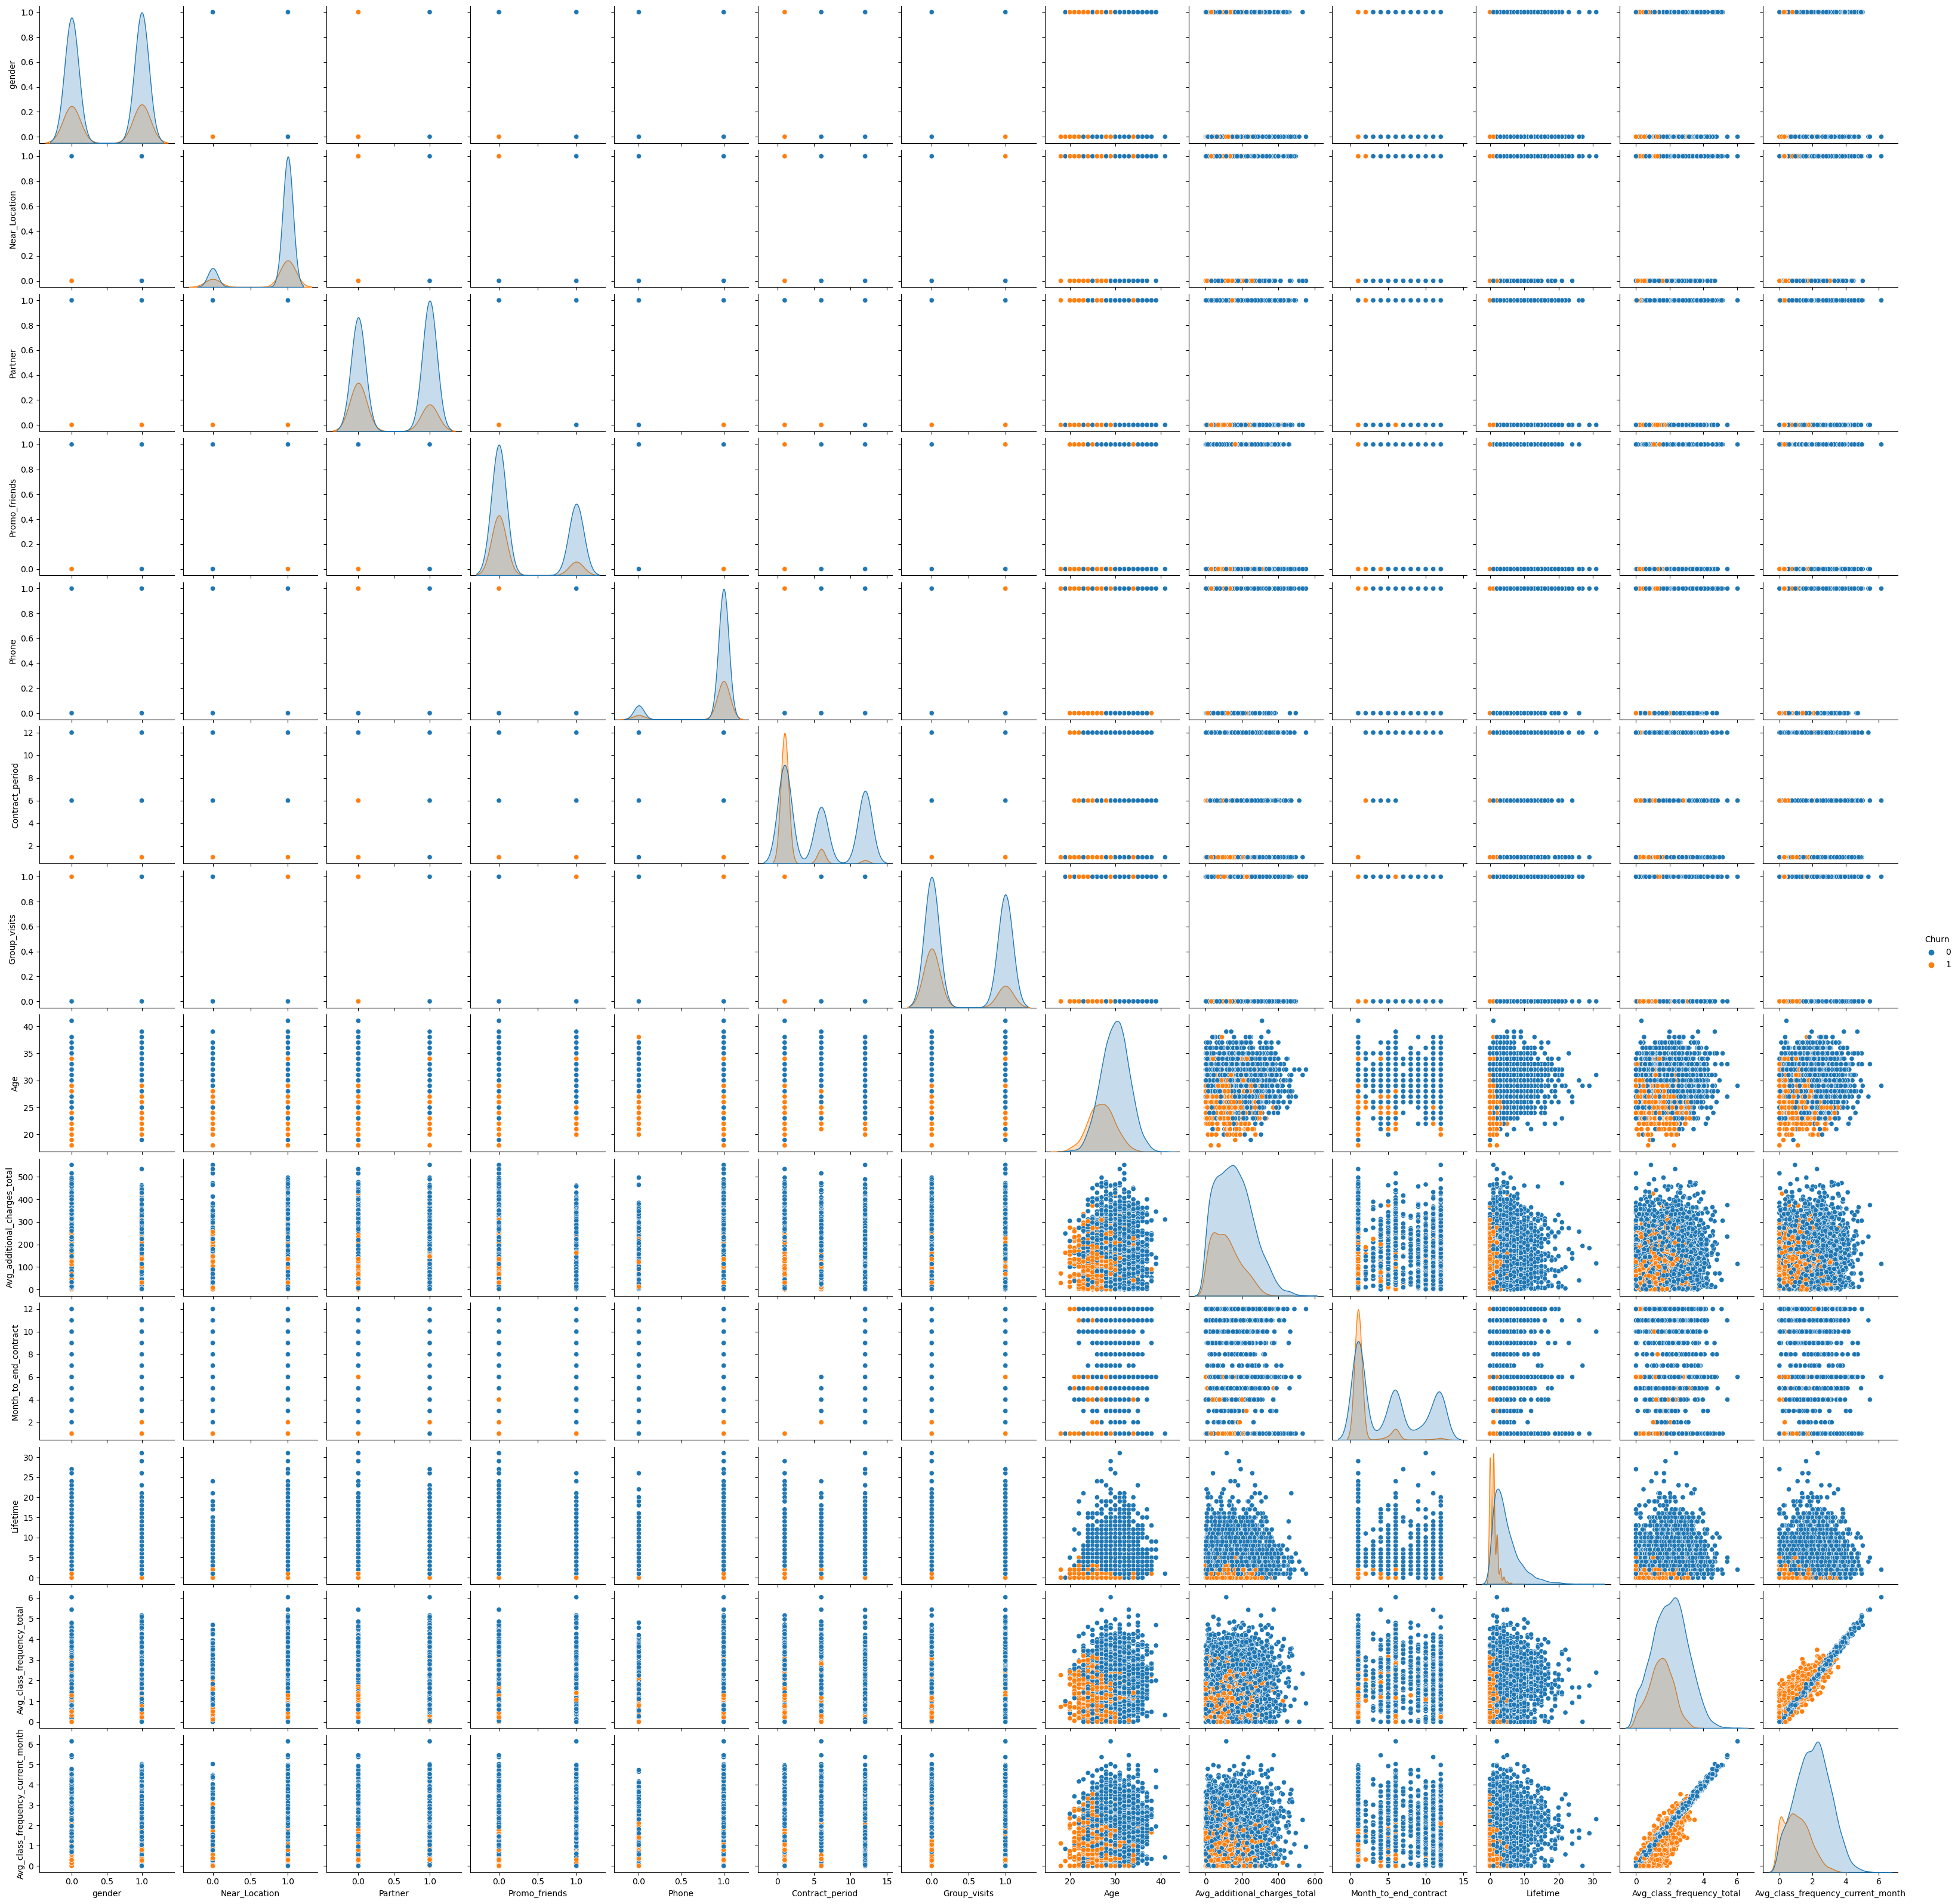

In [25]:
# Data Exploration
# Investigate relationships between features and target variable based on density
sns.pairplot(data, hue='Churn', diag_kind='kde')
plt.show()


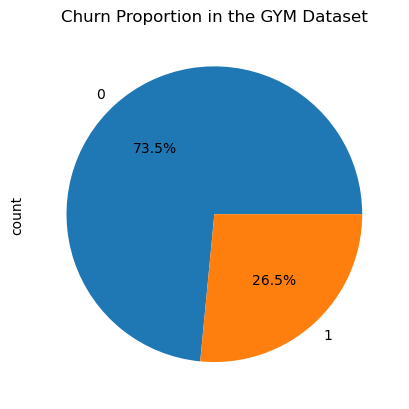

In [26]:
#showing attrition in proportion to the total records.
# Choosing pie chart as attrition attribute has two nominal values 'yes' and 'no'
data['Churn'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Churn Proportion in the GYM Dataset")
plt.show()

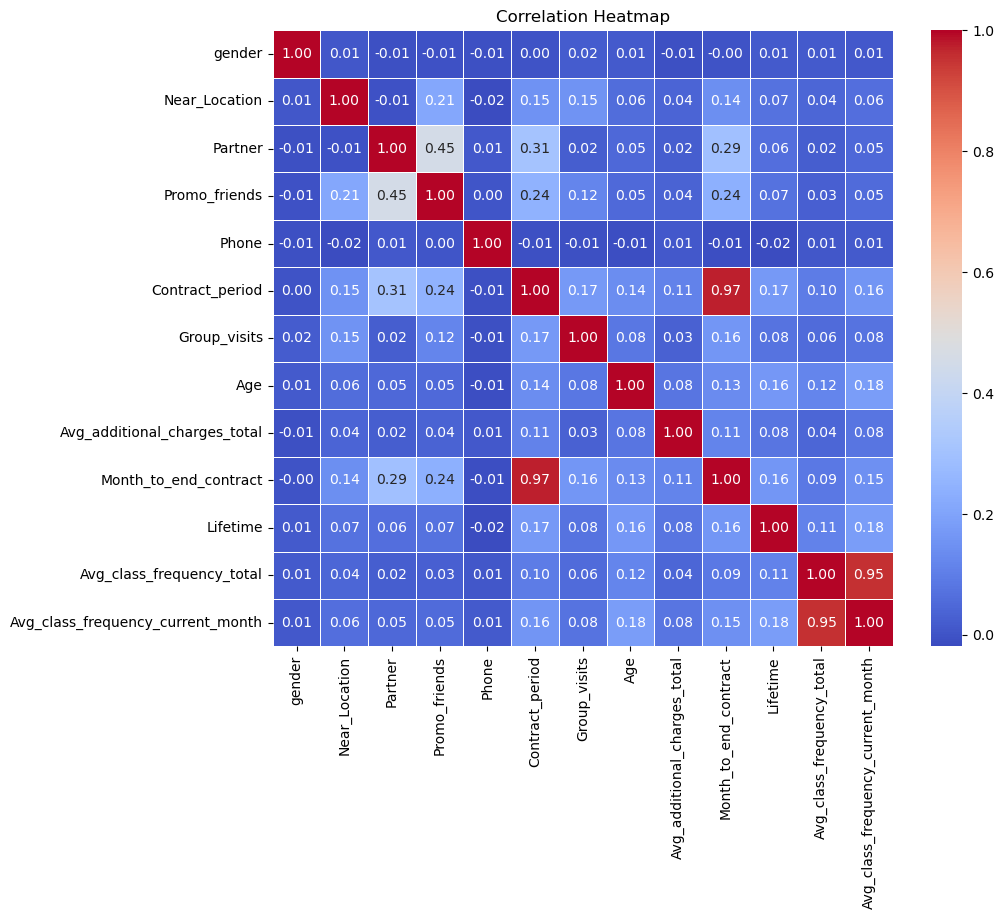

In [29]:
data_x_variables = data.drop('Churn', axis=1)
data_corr = data_x_variables.corr()
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [30]:
# Select relevant features (dropping the )
X = data.drop(['Churn'], axis=1)
y = data['Churn']

# Churn is the target variable
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Feature scaling (z score normalization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Encode target variable 'y_train' and 'y_test' (0 is No and 1 is Yes)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# PCA and Scaling applied to Machine Learning Models


In [32]:
# Model Training
# Try different models

models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()

}
accuracy_scores = {}


#Applying PCA to the scaled features
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), (name, model)])
    pipe.fit(X_train_scaled, y_train_encoded)


    # Model Evaluation (predicting target variable and calculating accuracy)
    y_pred = pipe.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    accuracy_scores[name] = accuracy
    print("---------------------------------------------------------------------")
    print(f'{name} accuracy: {accuracy}')

    # Print classification report
    print(f'Classification Report for {name}:')
    print(classification_report(y_test_encoded, y_pred))

    # Hyperparameter tuning for random forest
    if name == 'Random Forest':
        param_grid = {
            'Random Forest__n_estimators': [50, 100, 200],
            'Random Forest__max_depth': [None, 10, 20]
        }
        grid_search = GridSearchCV(pipe, param_grid, cv=5)
        grid_search.fit(X_train_scaled, y_train_encoded)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        print(f'Best {name} accuracy after hyperparameter tuning: {accuracy}')
        print(f'Classification Report for best {name} :')
        print(classification_report(y_test_encoded, y_pred))

    #Hyperparameter tuning for knn
    elif name == 'KNN':
        knn_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)), ('knn', KNeighborsClassifier())])
        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 9],
            'knn__weights': ['uniform', 'distance'],
            'knn__p': [1, 2]
        }
        grid_search = GridSearchCV(knn_pipe, param_grid, cv=5)
        grid_search.fit(X_train_scaled, y_train_encoded)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        print(f'Best {name} accuracy after hyperparameter tuning: {accuracy}')

        # Get the best hyperparameters
        best_params = grid_search.best_params_
        print(f'Best hyperparameters for {name}:',  best_params)
        print(f'Classification Report for best {name}:')
        print(classification_report(y_test_encoded, y_pred))

     

---------------------------------------------------------------------
KNN accuracy: 0.85375
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       576
           1       0.74      0.75      0.74       224

    accuracy                           0.85       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.85      0.85      0.85       800

Best KNN accuracy after hyperparameter tuning: 0.87125
Best hyperparameters for KNN: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Classification Report for best KNN:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       576
           1       0.78      0.75      0.77       224

    accuracy                           0.87       800
   macro avg       0.84      0.83      0.84       800
weighted avg       0.87      0.87      0.87       800

--------------------------------------

# Inference on Model Results::


### 1) K-Nearest Neighbors (KNN):

KNN showed significant improvement after hyperparameter tuning, achieving an accuracy of 0.87125.

### 2) Logistic Regression:

Logistic Regression exhibited a higher accuracy of around 90% compared to KNN, with better precision, recall, and F1-score for predicting churn.

### 3) Random Forest:

The Random Forest model achieved an accuracy of around 88%, with precision, recall, and F1-score for predicting churn.


### 4) Support Vector Machine (SVM):

SVM exhibited an accuracy of about 89% with relatively balanced precision and recall for predicting churn.

### 5) XGBoost:

XGBoost, a gradient boosting algorithm, achieved an accuracy of about 87% with similar precision, recall, and F1-score for predicting churn as other models.

# Conclusion:

Logistic Regression and SVM seem to be the best performers on this dataset. Given their high accuracy and balanced classification reports, they are good candidates for further tuning and evaluation.
Random Forest is a solid performer and might benefit from further hyperparameter tuning.
KNN showed good improvement after tuning, making it a viable option.
XGBoost is also a strong candidate, particularly for its ability to handle complex patterns, but it might need more extensive tuning to match the performance of Logistic Regression and SVM.